In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ
from statsmodels.tsa.forecasting.theta import ThetaModel
from datetime import datetime, timedelta

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('once')

Functions

In [20]:
def sample_data_with_train_window(df, start_date, end_date, train_window_size):
  start_date = datetime.strptime(start_date, '%Y-%m-%d') - timedelta(hours=train_window_size)
  end_date = datetime.strptime(end_date, '%Y-%m-%d') + timedelta(hours=23)
  return df[(df.index >= start_date) & (df.index <= end_date)]

def get_next_window(data, train_window_size, forecast_horizon):
  return data[:train_window_size], data[train_window_size:train_window_size + forecast_horizon]

def forecast_whitebox_model(model, forecast_horizon, model_name, exog_data_test=None):
  model_res = model.fit(disp=0)

  if "SARIMA" in model_name:
    return model_res.get_forecast(steps=forecast_horizon, exog=exog_data_test).predicted_mean
  else:
    return model_res.forecast(steps=forecast_horizon)

def save_stats(runtime, config_name, df_predictions, df_true):
  df_predictions.to_csv(f'../Results/Whitebox/Forecasting/{config_name}.csv', header=False)

  try:
    df_stats = pd.read_csv('../Results/Whitebox/Forecasting/whitebox_runtime.csv')
  except:
    df_stats = pd.DataFrame(columns=['model', 'runtime', 'mse', 'rmse', 'mae', 'mape'])

  new_row = {'model': config_name, 'runtime': runtime, 
             'mse': mean_squared_error(df_predictions, df_true),
             'rmse': root_mean_squared_error(df_predictions, df_true), 
             'mae': mean_absolute_error(df_predictions, df_true),
             'mape': mean_absolute_percentage_error(df_predictions, df_true)}
  df_stats = pd.concat([df_stats, pd.DataFrame([new_row])], ignore_index=True)
  df_stats = df_stats.sort_values(by=['model', 'rmse'], ascending=True).reset_index(drop=True)

  df_stats.to_csv('../Results/Whitebox/Forecasting/whitebox_runtime.csv', index=False)


Initializing time series

In [5]:
# Consumption data
df = pd.read_csv('../Dataset/ConsumptionIndustry.csv', sep=';')
df['HourDK'] = pd.to_datetime(df['HourDK'])
df['ConsumptionkWh'] = df['ConsumptionkWh'].str.replace(",", ".").astype(float)
df.index = df['HourDK']

# format data here
df.drop(columns=['HourUTC', 'HourDK', 'MunicipalityNo', 'Branche'], inplace=True)

In [24]:
model_name = 'SARIMAX'
date_start = '2023-11-01'
date_end = '2024-11-30'
window_train_size = 1440
forecast_horizon = 336

data = sample_data_with_train_window(df, date_start, date_end, window_train_size)
exog_data = sample_data_with_train_window(df2, date_start, date_end, window_train_size) # change w/ w/o exog_data
results = np.array([])
iterations = 0
max_iterations = math.ceil(len(df[(df.index >= date_start)]) / forecast_horizon)

while len(data) > window_train_size:
  data_train, data_test = get_next_window(data, window_train_size, forecast_horizon)
  iterations += 1
  print(f'Iteration {iterations}/{max_iterations}')
  data = data.iloc[forecast_horizon:]

Iteration 1/29
Iteration 2/29
Iteration 3/29
Iteration 4/29
Iteration 5/29
Iteration 6/29
Iteration 7/29
Iteration 8/29
Iteration 9/29
Iteration 10/29
Iteration 11/29
Iteration 12/29
Iteration 13/29
Iteration 14/29
Iteration 15/29
Iteration 16/29
Iteration 17/29
Iteration 18/29
Iteration 19/29
Iteration 20/29
Iteration 21/29
Iteration 22/29
Iteration 23/29
Iteration 24/29
Iteration 25/29
Iteration 26/29
Iteration 27/29
Iteration 28/29
Iteration 29/29
Iteration 30/29
Iteration 31/29
Iteration 32/29
Iteration 33/29
Iteration 34/29
Iteration 35/29
Iteration 36/29
Iteration 37/29
Iteration 38/29
Iteration 39/29
Iteration 40/29
Iteration 41/29
Iteration 42/29
Iteration 43/29
Iteration 44/29
Iteration 45/29
Iteration 46/29
Iteration 47/29
Iteration 48/29
Iteration 49/29
Iteration 50/29
Iteration 51/29
Iteration 52/29
Iteration 53/29
Iteration 54/29
Iteration 55/29
Iteration 56/29
Iteration 57/29
Iteration 58/29
Iteration 59/29
Iteration 60/29
Iteration 61/29
Iteration 62/29
Iteration 63/29
I

: 

In [6]:
# El-spot prices
df2 = pd.read_csv('../Dataset/ELSpotPrices.csv', sep=';')
df2['HourDK'] = pd.to_datetime(df2['HourDK'])
df2['SpotPriceDKK'] = df2['SpotPriceDKK'].str.replace(",", ".").astype(float)
df2.index = df2['HourDK']
df2 = df2.iloc[1:] # remove first row, since the measurement at that time is not present in other dataset
df2.drop(columns=['HourUTC', 'HourDK', 'PriceArea', 'SpotPriceEUR'], inplace=True)

Runs a model in Sliding Window forecasting style

In [23]:
model_name = 'SARIMAX'
date_start = '2023-11-01'
date_end = '2024-11-30'

# List of (window_train_size, forecast_horizon) tuples
configurations = [
    # (336, 24),      # 336 hours, 24 hours forecast horizon
    (1440, 336),    # 1440 hours, 336 hours forecast horizon
    # (17520, 8760)   # 17520 hours, 8760 hours forecast horizon
]

for window_train_size, forecast_horizon in configurations:
  config_name = f'{model_name}_{window_train_size}_{forecast_horizon}'

  warnings.filterwarnings("ignore")

  start_time = time.time()

  data = sample_data_with_train_window(df, date_start, date_end, window_train_size)
  exog_data = sample_data_with_train_window(df2, date_start, date_end, window_train_size) # change w/ w/o exog_data
  results = np.array([])
  iterations = 0
  max_iterations = math.ceil(len(df[(df.index >= date_start)]) / forecast_horizon)

  scaler = MinMaxScaler()

  while len(data) > window_train_size:
    data_train, data_test = get_next_window(data, window_train_size, forecast_horizon)
    exog_data_train, exog_data_test = get_next_window(exog_data, window_train_size, forecast_horizon)

    data_train_scaled = scaler.fit_transform(data_train[['ConsumptionkWh']])
    data_train = pd.DataFrame(data_train_scaled, columns=['ConsumptionkWh'], index=data_train.index)
    model = SARIMAX(data_train, order=(0, 1, 0), seasonal_order=(2, 1, 2, 12), exog=exog_data_train) # change w/ w/o exog_data_train

    for attempt in range(5):
      try:
        predictions_scaled = forecast_whitebox_model(model, forecast_horizon, model_name, exog_data_test) # change w/ w/o exog_data_test
        predictions = scaler.inverse_transform(predictions_scaled.values.reshape(-1, 1))
        predictions = pd.Series(predictions.flatten(), index=data_test.index)
        break
      except Exception as e:
        print(f'Attempt {attempt+1} failed: {e}')
        if attempt == 4:
          raise RuntimeError(f'Model failed to fit and forecast after 5 attempts at iteration {iterations}')

    results = np.append(results, predictions.values)
    data = data.iloc[forecast_horizon:]
    exog_data = exog_data.iloc[forecast_horizon:] # change w/ w/o exog_data
    
    iterations += 1
    print(f'{config_name}: Iteration {iterations}/{max_iterations}')

  end_time = time.time()

  warnings.filterwarnings("default")

  df_predictions = pd.DataFrame(results)
  df_predictions.index = pd.date_range(start=date_start, periods=forecast_horizon*iterations, freq='h')
  df_predictions = df_predictions[(df_predictions.index < '2024-12-01')] # remove predictions for December 2023

  save_stats(runtime=end_time - start_time, config_name=config_name, df_predictions=df_predictions, df_true=data)

SARIMAX_1440_336: Iteration 1/29
SARIMAX_1440_336: Iteration 2/29
SARIMAX_1440_336: Iteration 3/29
SARIMAX_1440_336: Iteration 4/29
SARIMAX_1440_336: Iteration 5/29
SARIMAX_1440_336: Iteration 6/29
SARIMAX_1440_336: Iteration 7/29
SARIMAX_1440_336: Iteration 8/29
SARIMAX_1440_336: Iteration 9/29
SARIMAX_1440_336: Iteration 10/29
SARIMAX_1440_336: Iteration 11/29
SARIMAX_1440_336: Iteration 12/29
SARIMAX_1440_336: Iteration 13/29
SARIMAX_1440_336: Iteration 14/29
SARIMAX_1440_336: Iteration 15/29
SARIMAX_1440_336: Iteration 16/29
SARIMAX_1440_336: Iteration 17/29
SARIMAX_1440_336: Iteration 18/29
SARIMAX_1440_336: Iteration 19/29
SARIMAX_1440_336: Iteration 20/29
SARIMAX_1440_336: Iteration 21/29
SARIMAX_1440_336: Iteration 22/29
SARIMAX_1440_336: Iteration 23/29
SARIMAX_1440_336: Iteration 24/29
SARIMAX_1440_336: Iteration 25/29
SARIMAX_1440_336: Iteration 26/29
SARIMAX_1440_336: Iteration 27/29
SARIMAX_1440_336: Iteration 28/29
Attempt 1 failed: Provided exogenous values are not of th

RuntimeError: Model failed to fit and forecast after 5 attempts at iteration 28

Plot of forecasts

-- SARIMA --
mae: 4300.401658450579
mse: 32538872.417222656
rmse: 5704.28544317539


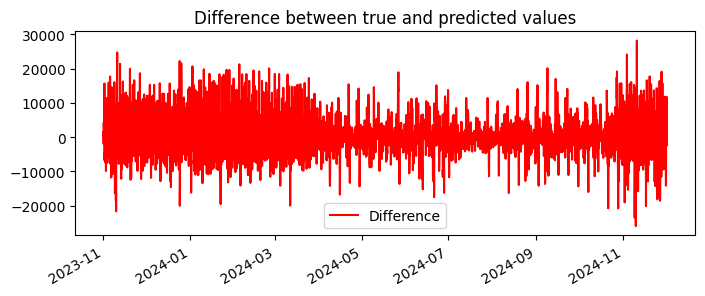

In [ ]:
def evaluate(prediction, data, name):
    print(f"-- {name} --")
    print(f"mae: {mean_absolute_error(data, prediction)}")
    print(f"mse: {mean_squared_error(data, prediction)}")
    print(f"rmse: {root_mean_squared_error(data, prediction)}")

prediction = pd.read_csv('../Results/Whitebox/Forecasting/SARIMA_336_24.csv', header=None, index_col=0, names=['Prediction'])
prediction.index = pd.to_datetime(prediction.index)

data = df.tail(len(prediction))
difference = data['ConsumptionkWh'] - prediction['Prediction']

evaluate(prediction['Prediction'], data, 'SARIMA')

fig, ax = plt.subplots(figsize=(8, 3))
difference.plot(ax=ax, label='Difference', color='red')
ax.set_title('Difference between true and predicted values')
ax.legend()

Evaluate algorithm performance